This is a example for the InSAR damage map based calculation of explosive yield as used in:

Pilger, C., Gaebler, P., Hupe, P. et al. Yield estimation of the 2020 Beirut explosion using open access waveform and remote sensing data. Sci Rep 11, 14144 (2021). https://doi.org/10.1038/s41598-021-93690-y

The blast of the explosion caused a wide range of damages to buildings. The reflection of radar waves from SAR satellites is strongly depending on the ground structure down to a decimeter level, with a sensitivity to less than a centimeter of motion. In areas of Beirut where the outsides of buildings have been significantly damaged, space-borne SAR images showing the backscattered amplitude and phase of radar waves before and after the explosion therefore differ. To quantify this difference and thereby approximating the building damage, we use a combined measure of the amplitude and phase similarity in multitemporal SAR image pixels, the interferometric coherence, and we relate changes in this measure to damage.

We assume a relation between peak overpressure and resulting damage. Damage to structures caused by the external force of an explosion will first act on the external surface of affected structures. We think it is therefore reasonable to assume a relation between the density of the with InSAR data observed changes to surfaces in an area, as described by the damage proxy, and the explosion force causing overpressure-related damage to structures. Observations of peak-overpressure damage relation observations can be found here:
https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470938157.app2
(CCPS. Appendix B: Effects of explosions on structures to the original version of “Guidelines for evaluating the characteristics of vapor cloud explosions, flash fires, and BLEVEs” (Center for Chemical Process Safety of the American Institute of Chemical, 1994)

And here:
https://www.researchgate.net/publication/329361955_REVIEW_OF_THE_BASICS_OF_STATE_OF_THE_ART_OF_BLAST_LOADING/figures?lo=1



In [1]:
# Numpy, rasterio, matplotlib, affine and shapefile (pyshp) are needed
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from pyrocko import orthodrome
from affine import Affine
from pyproj import Proj, transform
import shapefile
import matplotlib
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
matplotlib.rcParams.update({'font.size': 22})
km = 1000.
geer_dataset = False


def overpressure(w, dist, atmo=1006):
    '''
    "BOOM" empirical relation between yield and overpressure 
    https://apps.dtic.mil/dtic/tr/fulltext/u2/a182025.pdf
    Eq. 6:
    P = 103.1 + 20 * log10((S/1013)^0.556 * ((w2/2.2)/110)^0.444 * (25/(rm/1000))^1.333)
    with: 
        P = Peak overpressure (dB)
        S = Atmospheric pressure (mbar)
        w2 = TNTe
        rm = Measurement distance (m)
    Converted here to a simpler form for ease of handling.

    input parameters:
    w : yield in kT
    dist : distance in m
    atmo: atmospheric pressure, 1006 Pa from ECMWF data between 12 and 18 UTC at Beirut Port.
    '''


    P = (3.45978*(10**3)*(w**0.444) * (atmo**0.556) )/ (dist**1.33)

    return P




def to_latlon(fname):
    '''
    Helper function to assign latitude and longitude.
    '''

    # Read raster
    with rasterio.open(fname) as r:
        T0 = r.transform  # upper-left pixel corner affine transform
        p1 = Proj(r.crs)
        A = r.read()  # pixel values

    # All rows and columns
    cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: (c, r) * T1

    # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

    # Project all longitudes, latitudes
    p2 = Proj(proj='latlong', datum='WGS84')
    longs, lats = transform(p1, p2, eastings, northings)
    return longs, lats



def get_coords_from_geotiff(fname, array):
    '''
    Helper function to get coordinates from geotiff.
    '''
    with rasterio.open(fname) as r:
        T0 = r.transform  # upper-left pixel corner affine transform
    cols, rows = np.meshgrid(np.arange(array.shape[1]),
                              np.arange(array.shape[0]))
    T1 = T0 * Affine.translation(0.5, 0.5)
    rc2en = lambda r, c: (c, r) * T1
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)
    return eastings, northings


def updatescatter(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([64])

def updateline(handle, orig):
    handle.update_from(orig)
    handle.set_markersize(8)


We now make a InSAR damage proxy map from SAR images before and after the explosion. A large drop of coherence may occur when e.g. buildings collapse, while a small coherence drop can be caused by e.g. damages of building facades.
The size of the estimation window used for coherence estimation is a trade-off between overestimation of coherence for small window sizes.

If a pixel in any of the four coherence maps shows significant coherence loss, we assign a damage pixel in the combined binary image. Further we consider a high density of damage pixels in form of area percentage is a proxy for high damage to individual structures in that area. We calculate the percentage of damage pixels in a 10 by 10 pixel window (roughly 100 by 100 m), which forms the damage proxy map.

In [2]:
# data names:

fps_asc = ['subset_2_of_asc_Orb_Stack_Ifg_Deb_TC.tif']
fps_dsc = ['subset_1_of_dsc_coreg_Orb_Stack_Ifg_Deb_TC.tif']
# open data
raster_asc = rasterio.open(fps_asc[0])
raster_dsc = rasterio.open(fps_dsc[0])

# Each file contains several images

# Band 1 intensity
# Band 2 original coherence
# Band 3 3x3 Moving average coherence
# Band 4 - 'pre' -  5x5 Moving average coherence
# Band 4 - 'co' - 7x7 Moving average coherence
# Band 5 - 'pre' - 7x7 Moving average coherence
# Band 5 - 'co' - 5x5 Moving average coherence
# Pre - SAR image from before explosion
# co - SAR image after explosion

band_pre_asc = raster_asc.read(4)
band_co_asc = raster_asc.read(2)
band_pre_dsc = raster_dsc.read(4)
band_co_dsc = raster_dsc.read(2)
band_elevation = raster_dsc.read(5)

#########################################################
# calculate difference

coh_diff_asc = band_pre_asc - band_co_asc
coh_diff_dsc = band_pre_dsc - band_co_dsc

# threshold coherence difference
threshold_cc = 0.4
coh_diff_mask_asc = np.where(coh_diff_asc<threshold_cc, 0., 1.)
coh_diff_mask_dsc = np.where(coh_diff_dsc<threshold_cc, 0., 1.)



# Add
coh_diff_mask_combi = coh_diff_mask_asc + coh_diff_mask_dsc
coh_diff_mask_combi = np.where(coh_diff_mask_combi<1., 0., 1.)


# calculate damage in windows
step = 10
sz_asc = np.shape(coh_diff_asc)
iwin_row = np.arange(0, sz_asc[0], step)
iwin_col = np.arange(0, sz_asc[1], step)

coh_diff_changecount_asc = np.zeros((len(iwin_row), len(iwin_col)))
coh_diff_changecount_dsc = np.zeros((len(iwin_row), len(iwin_col)))
coh_diff_changecount_combi = np.zeros((len(iwin_row), len(iwin_col)))



for ir, row in enumerate(iwin_row):
    for ic, col in enumerate(iwin_col):
        coh_diff_changecount_asc[ir, ic] = \
            np.sum(coh_diff_mask_asc[row:row+step,
                              col:col+step].flatten())
        coh_diff_changecount_dsc[ir, ic] = \
            np.sum(coh_diff_mask_dsc[row:row+step,
                              col:col+step].flatten())
        coh_diff_changecount_combi[ir, ic] = \
            np.sum(coh_diff_mask_combi[row:row+step,
                              col:col+step].flatten())

# Relative damage
coh_diff_changecount_asc /= (step*step)
coh_diff_changecount_dsc /= (step*step)
coh_diff_changecount_combi /= (step*step)

coh_diff_changecount_asc *= 100
coh_diff_changecount_dsc *= 100
coh_diff_changecount_combi *= 100

# Write relative damage pixels to geotiff.
with rasterio.Env():
    profile = raster_dsc.profile
    profile.update(
        dtype=rasterio.float64,
        count=1,)

    with rasterio.open('comb_damage_example.tif', 'w', **profile) as dst:
        dst.write(coh_diff_changecount_combi, 1)



In [3]:
# read relative damage map
fname = 'comb_damage_example.tif'
comb = rasterio.open(fname)
longs, lats = to_latlon(fname)
damage_img = comb.read(1)

eastings, northings = get_coords_from_geotiff(fname, damage_img)

# hardcode the explosion location for distance calculation
explosion_lat = 33.901634
explosion_lon = 35.5188865

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: Right multiplication will be prohibited in version 3.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: Right multiplication will be prohibited in version 3.0


In [4]:
threshold = 1 # minimum relative damage value to consider in calculations
damage_values = []
distances = []

for col in range(np.shape(damage_img)[0]):
    for row in range(0, np.shape(damage_img)[1]):
        north = northings[col, row]
        east = eastings[col, row]
        val = damage_img[col, row]
        if val > threshold:
            dist = orthodrome.distance_accurate50m(explosion_lon,
                                           explosion_lat,
                                           east,
                                           north)


            distances.append(dist)
            damage_values.append(val)


We set 80 kPa peak overpressure to result in 100% damage to all structures.
We further scale damage using a log10.
We motivate our assumption of a common-logarithmic relationship between damage and peak overpressure by a similar empirical common-logarithmic relation between earthquake moment and earthquake damages.

In [5]:
max_damage = 80 # kPa; will result in 100% damage
scale_fac = 100/np.log10(max_damage)

# yield in kt to calculate for:
wtnts = [0.1, 0.4, 0.8, 1.1, 1.4, 2.]


Calculate the yield - damage relation for all given yields:

In [6]:
damage_fwds = []
for wtnt in wtnts:
    damage_fwd = []
    for dist in distances:
        damage_fwd.append(np.log10(overpressure(wtnt, dist))*scale_fac)
    damage_fwds.append(damage_fwd)


We hardcode now some "ground-truth" to check the valdidity of our assumptions; see table 4 in our paper.

N 	Locality 	Distance (km) 	Est, damage 	% of coherence loss 	kPA  %Damage
1 	Sursock Palace 	0.9 	Partial demolition—partial collapse roof 	59 	7–15 	44.4–61.8
2 	Saint George hospital 	1 	Minor damage, partial demolition 	47.9 	8–15 	47.5–61.8
3 	Seaside Arena 	1.1 	Serious structural damage, collapse 	61.5–74.3 	18–40 	66–84.1
4 	Saint George church 	1.4 	Minor damage 	58.9 	7–15 	44.4–61.8.75
5 	Forum de Beyrouth 	1.5 	Metal buckled 	52–60 	7–15 	46.3–61.8
6 	Hotel Cavalier 	3 	Minor damage, buckling 	None 	3–7 	28.26–36 

In [7]:
# building [distance, min overpressure, max overpressure]
sursock_palace = [900., 7. , 15.]
saint_george_hospital = [1000., 8. , 15.]
beirut_sea_side = [1102., 18 , 40]
saint_george_cathedral = [1400., 7., 15.]
forum_de_beirut = [1500., 7.6 , 15]
hotel_cavalier = [3000, 3.45 , 5.]
beirut_airport = [9000., 3. , 5.]


An openly available report of on-site damage inspections of buildings throughout the city is available here:
https://www.designsafe-ci.org/data/browser/public/designsafe.storage.published/PRJ-3030
This can be used as further ground-truth (optional). This on-site damage report categorizes four damage classes which we relate to peak overpressure ranges as follows: 
class 1) 1 to 3.5 kPa, class 2) 3.5 to 7 kPa, class 3) 7 to 20 kPa and class 4) 20 to 60 kPa

In [8]:
# Read the GEER dataset an calculate the necessary overpressure to cause such damage.
sf = shapefile.Reader('PRJ-3030/Structural_damage_assessment/Structural_Damage_In_Person.shp')
buildings = sf.shapes()
damage_classes = []
damage_num = []
overpress_low = []
overpress_up = []
distance = []
for rec in sf.records():
    dc = rec.Damage_Cla
    ds = rec.Distance
    if len(dc) > 0:
        damage_classes.append(dc)
        if len(dc) == 2:
            damage = int(dc[1])
            damage_num.append(damage)

            if dc[1] == '1':
                overpress_low.append(1.)
                overpress_up.append(3.5)
            if dc[1] == '2':
                overpress_low.append(3.5)
                overpress_up.append(7.)
            if dc[1] == '3':
                overpress_low.append(7.)
                overpress_up.append(20.)
            if dc[1] == '4':
                overpress_low.append(20.)
                overpress_up.append(60.)

        elif len(dc) == 5:
            damage = (float(dc[1])+float(dc[4]))/2
            damage_num.append(damage)
            if dc[1] == '1':
                overpress_low.append(1.)
            if dc[1] == '2':
                overpress_low.append(4.)
            if dc[1] == '3':
                overpress_low.append(8.)
            if dc[1] == '4':
                overpress_low.append(20.)
            if dc[4] == '2':
                overpress_up.append(8.)
            if dc[4] == '3':
                overpress_up.append(20.)
            if dc[4] == '4':
                overpress_up.append(60.)
        distance.append(ds)

geer_dataset = True




/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


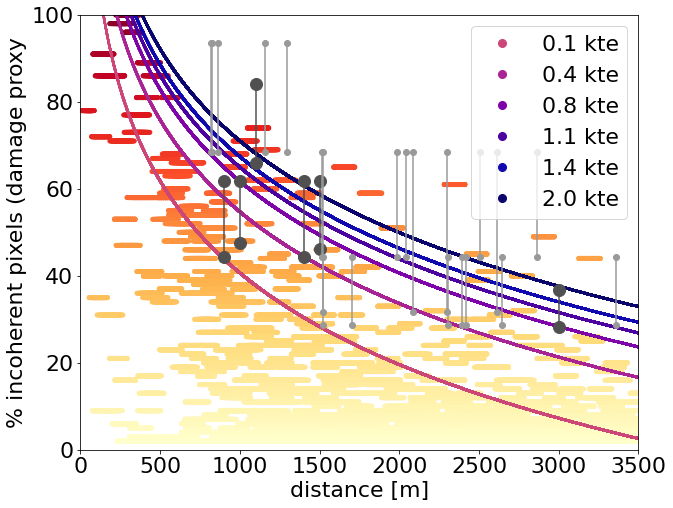

In [9]:
# Plotting

plt.figure(figsize=(10,8))
colors = ["#cc4778ff", "#aa2395ff", "#7e03a8ff", "#4c02a1ff", "#1009b0ff", "#0a056cff"] # for each yield

# Plot yield-damage curves
for i, damage_fwd in enumerate(damage_fwds):
    plt.plot(distances, damage_fwd, 'o', color=colors[i], label = '%s kte' % wtnts[i], markersize=1)

# Plot InSAR derived damage proxy
plt.scatter(distances, damage_values, c=damage_values, cmap='YlOrRd', s=16)

# Plot ground-truth:
plt.plot([saint_george_hospital[0], saint_george_hospital[0]], 
          [ np.log10(saint_george_hospital[1]) * scale_fac,
            np.log10(saint_george_hospital[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)

plt.plot([saint_george_cathedral[0], saint_george_cathedral[0]], 
          [ np.log10(saint_george_cathedral[1]) * scale_fac,
            np.log10(saint_george_cathedral[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)

plt.plot([forum_de_beirut[0], forum_de_beirut[0]], 
          [ np.log10(forum_de_beirut[1]) * scale_fac,
           np.log10(forum_de_beirut[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)

plt.plot([sursock_palace[0], sursock_palace[0]], 
          [ np.log10(sursock_palace[1]) * scale_fac,
          np.log10(sursock_palace[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)


plt.plot([hotel_cavalier[0], hotel_cavalier[0]], 
          [ np.log10(hotel_cavalier[1]) * scale_fac,
           np.log10(hotel_cavalier[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)

plt.plot([beirut_airport[0], beirut_airport[0]], 
          [ (beirut_airport[1]) * scale_fac,
           (beirut_airport[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)

plt.plot([beirut_sea_side[0], beirut_sea_side[0]], 
          [ np.log10(beirut_sea_side[1]) * scale_fac,
           np.log10(beirut_sea_side[2]) * scale_fac],
         'o-', color="#505050ff", linewidth = 1.5, markersize=12)

# Plot GEER ground-truth, optional:

if geer_dataset is True:
    for dist, p_low, p_up in zip(distance, overpress_low, overpress_up):
        if (p_up == 60.) & (dist <=1500):
            dam_low = np.log10(p_low)* scale_fac
            dam_up = np.log10(p_up)* scale_fac
            plt.plot([dist, dist], [dam_low, dam_up], 'o-', color=[0.6, 0.6, 0.6])

        elif dist >1500:
            dam_low = np.log10(p_low)* scale_fac
            dam_up = np.log10(p_up)* scale_fac
            if dam_low >10:
                    plt.plot([dist, dist], [dam_low, dam_up], 'o-', color=[0.6, 0.6, 0.6])


plt.axis([0., 3500., 0., 100.])
plt.xlabel('distance [m]')
plt.ylabel('% incoherent pixels (damage proxy')
plt.grid(False)


plt.legend(handler_map={PathCollection : HandlerPathCollection(update_func=updatescatter),
                        plt.Line2D : HandlerLine2D(update_func = updateline)})

plt.show()

Below 1000 m distance from the explosion, damage values higher than 40% are bound by a minimum yield of 0.4 kt TNT. We think that the explanation of the damage close to the explosion source is most important, as the overpressure will cause damage to the structures without attenuation or focusing effects. Also, we expect different vulnerabilities of individual structures possibly become more significant for lower overpressure values at greater distances. The damage close to the explosion source is best explained by a yield of 0.8-1.1 kt TNT. 

Here is an example on how to calculate a synthetic damage map using the Boom equation and a reference tiff - here for the Beirut area.

In [11]:
def synthetic_damage_map(w, damge_img, center):
    synthetic_damage = np.zeros(np.shape(damage_img))
    for col in range(np.shape(damage_img)[0]):
        for row in range(0, np.shape(damage_img)[1]):
            north = northings[col, row]
            east = eastings[col, row]
            dist = orthodrome.distance_accurate50m(explosion_lon,
                                           explosion_lat,
                                           east,
                                           north)
            damage = np.log10(overpressure(1.1, dist))*scale_fac
            synthetic_damage[col][row] = damage
            
    return synthetic_damage
    
synthetic_damage = synthetic_damage_map(1.1, damage_img, [explosion_lat, explosion_lon])    

In [12]:
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = raster_dsc.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.float64,
        count=1,)

    with rasterio.open('synthetic_damage.tif', 'w', **profile) as dst:
        dst.write(synthetic_damage, 1)